In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys  
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir
tweets_dir  = "/Users/caihao/Dropbox/TEMP/tweets/"

In [74]:
# test logistic regression model as baseline.
df = pd.read_csv(processed_data_dir + '/companies_all_labeled_final.csv')
# df = pd.read_csv(processed_data_dir + '/companies_all_labeled_final_2_sampled.csv')
# selected_features = ['funding_total_usd', 'all_tweet_num',\
#                      'preA_tweet_num', 'postA_tweet_num', 'preA_tweet_freq',\
#                      'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength',\
#                      'preA_tweet_content_richness', 'postA_tweet_content_richness',\
#                      'preA_tweet_interactiveness', 'postA_tweet_interactiveness',\
#                      'status_feature', 'country_feature', 'age_feature',\
#                      'days_since_first_funding', 'tweet_num_change', 'tweet_freq_change',\
#                      'tweet_avglength_change', 'tweet_content_richness_change',\
#                      'tweet_interactiveness_change', 'category_score', 'market_score',\
#                      'tweets_pos_topic_score', 'tweets_neg_topic_score',\
#                      'tweets_neg_sent_score', 'tweets_neu_sent_score',\
#                      'tweets_pos_sent_score', 'tweets_compound_sent_score',\
#                      'WILL',]
selected_features = ['country_feature', 'age_feature',\
                     'days_since_first_funding', 'category_score', 'market_score',\
                     'postA_tweet_num', 'postA_tweet_freq', 'postA_tweet_avglength',\
                     'postA_tweet_content_richness', 'postA_tweet_interactiveness',\
                     'tweets_pos_topic_score', 'tweets_neg_topic_score',\
                     'tweets_neg_sent_score', 'tweets_neu_sent_score',\
                     'tweets_pos_sent_score', 'tweets_compound_sent_score',\
                     'WILL',]

new_df = df[selected_features].copy()
print(new_df.head())
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values
print(X.shape, y.shape)

# new_df.to_csv(processed_data_dir + '/model_lr3_rf2_xgb2_data.csv', index=False)
# Fix: update category_score to sklearn scores.
# new_category_score = pd.read_csv(processed_data_dir + '/companies_all_category_scores_sklearn.txt',
#                                  delimiter='\s+', names=['new_category_score'], index_col=0)
# new_df['category_score'] = new_category_score['new_category_score']
# new_df.to_csv(processed_data_dir + '/model_lr3_rf2_xgb2_data1.csv', index=False)

   country_feature  age_feature  days_since_first_funding  category_score  \
0                0       1953.0                      2070     1804.887064   
1                1       2678.0                      1917     2430.877540   
2                0       1644.0                      1735     1212.675016   
3                0       1825.0                      1644        0.000000   
4                0       1071.0                      1309     2062.537164   

   market_score  postA_tweet_num  postA_tweet_freq  postA_tweet_avglength  \
0    256.914435              551          7.503891             113.822142   
1    173.059769             3170         33.218563             115.986435   
2    333.135955              294          1.599068             100.496599   
3      0.000000              169          3.917219             126.597633   
4    178.445148              280          5.384615              95.125000   

   postA_tweet_content_richness  postA_tweet_interactiveness  \
0         

In [75]:
import seaborn as sns

new_df[new_df.postA_tweet_interactiveness<100].postA_tweet_interactiveness.value_counts(bins=10)

(-0.07100000000000001, 7.0]    3750
(7.0, 14.0]                      50
(14.0, 21.0]                     24
(21.0, 28.0]                      5
(42.0, 49.0]                      4
(63.0, 70.0]                      3
(35.0, 42.0]                      3
(28.0, 35.0]                      3
(56.0, 63.0]                      0
(49.0, 56.0]                      0
Name: postA_tweet_interactiveness, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24bda5c0>,
      dtype=object)

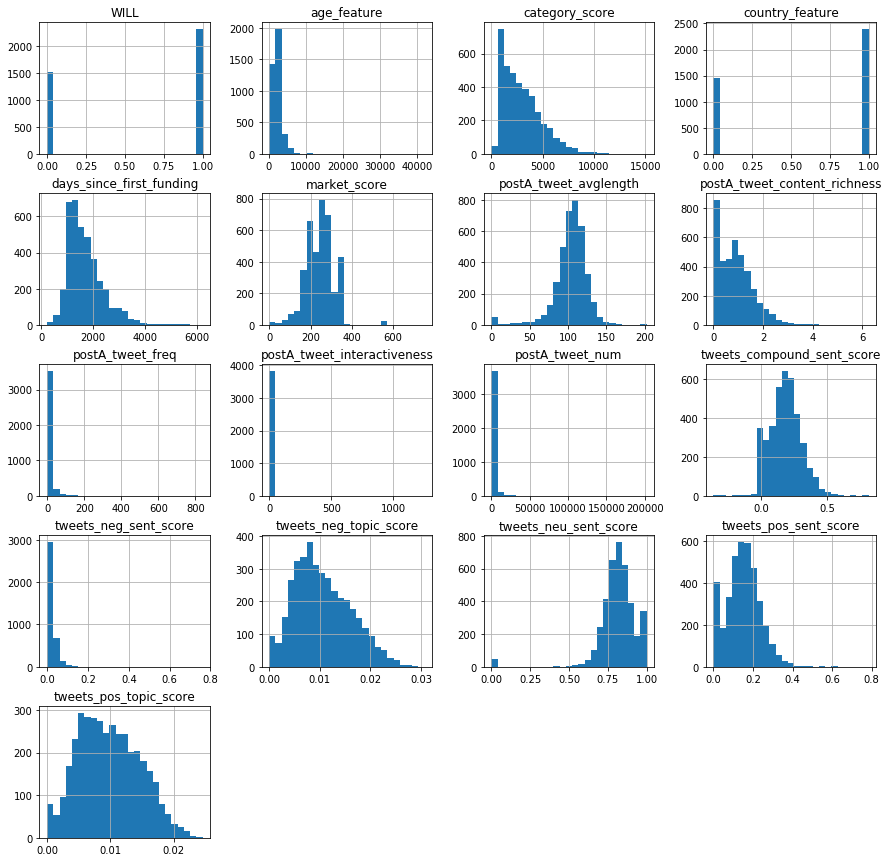

In [76]:
new_df.hist(bins=25, figsize=(15,15))

In [77]:
import seaborn as sns

# get mean values for backend inference.
print('interactiveness', new_df.postA_tweet_interactiveness.mean())
print('pos_topic_score', new_df.tweets_pos_topic_score.mean())
print('neg_topic_score', new_df.tweets_neg_topic_score.mean())
print('neg_sent_score', new_df.tweets_neg_sent_score.mean())
print('neu_sent_score', new_df.tweets_neu_sent_score.mean())
print('pos_sent_score', new_df.tweets_pos_sent_score.mean())
print('compound_sent_score', new_df.tweets_compound_sent_score.mean())

# sns.boxplot(x='WILL', y='postA_tweet_interactiveness', data=new_df)
# sns.scatterplot(x='postA_tweet_num', y='postA_tweet_freq', data=new_df)

interactiveness 2.0397404041896086
pos_topic_score 0.009812695518409409
neg_topic_score 0.010592360944776448
neg_sent_score 0.021841279446969068
neu_sent_score 0.812420437686509
pos_sent_score 0.15154393868437746
compound_sent_score 0.18161318764872886


In [78]:
# we see that 'postA_tweet_num' and 'postA_tweet_freq' has positive correlation. Here I want to do linear regression\
# to get a slope to use in my back-end application.
from scipy.stats import linregress

x_ = new_df['postA_tweet_num']
y_ = new_df['postA_tweet_freq']

slope, intercept, r_value, p_value, std_err = linregress(x_, y_)
print(slope)

0.003925651055633885


In [79]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# logistic regression with cross-validation.
# clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X, y)
clf = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=5
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
    )
clf.fit(X, y)


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=777, refit=True, scoring='roc_auc',
                     solver='newton-cg', tol=10, verbose=0)

In [80]:
# look at important features.
print(pd.Series((np.std(X, 0)*clf.coef_)[0, :], index=selected_features[:-1]))

country_feature                   0.274811
age_feature                       0.016197
days_since_first_funding          0.167692
category_score                    0.113717
market_score                      0.070885
postA_tweet_num                 220.056659
postA_tweet_freq                -54.535614
postA_tweet_avglength            -0.050234
postA_tweet_content_richness      0.129746
postA_tweet_interactiveness       1.146147
tweets_pos_topic_score            0.000045
tweets_neg_topic_score           -0.000130
tweets_neg_sent_score            -0.000288
tweets_neu_sent_score             0.017456
tweets_pos_sent_score            -0.004748
tweets_compound_sent_score       -0.005960
dtype: float64


In [9]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_logreg_3.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_logreg_3.pkl', 'rb'))
print(new_clf.predict(X))

[1 1 1 ... 0 1 1]


In [81]:
# Grid search for logistic model.
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, y)

print('Best Penalty: ', best_model.best_estimator_.get_params()['penalty'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Penalty:  l2
Best C:  59.94842503189409


In [82]:
# The above code finds the values for Best penalty as ‘xxx’ and best C is ‘xxx’.
# Now let’s use these values and calculate the accuracy.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS

# all scoring metrics
# print(sorted(SCORERS.keys()))

# cross-validation.
kfold = KFold(n_splits=5, random_state=7)
model = LogisticRegression(C=1, penalty='l2')
result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
print("Accuracy: ", result.mean())

Accuracy:  0.9214986573894246


In [83]:
# Random forest model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Create the model with 100 trees
clf = RandomForestClassifier(max_depth=5, n_estimators=20, random_state=7, oob_score=True)
clf.fit(X_train, y_train)

# Accuracy
print("Accuracy: ", clf.score(X_test, y_test))
print("OOB score: ", clf.oob_score_)

# feature importances.
print(pd.Series(clf.feature_importances_, index=selected_features[:-1]))

Accuracy:  0.8432900432900433
OOB score:  0.8205794947994056
country_feature                 0.037057
age_feature                     0.032237
days_since_first_funding        0.112730
category_score                  0.008287
market_score                    0.007865
postA_tweet_num                 0.266924
postA_tweet_freq                0.077630
postA_tweet_avglength           0.016063
postA_tweet_content_richness    0.068879
postA_tweet_interactiveness     0.095758
tweets_pos_topic_score          0.160488
tweets_neg_topic_score          0.078376
tweets_neg_sent_score           0.012471
tweets_neu_sent_score           0.011336
tweets_pos_sent_score           0.008250
tweets_compound_sent_score      0.005648
dtype: float64


In [13]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_rf_2.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_rf_2.pkl', 'rb'))
print(new_clf.predict(X_test))

[0 0 1 ... 0 1 0]


In [84]:
# XGBoost model.
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# split training feature and target sets into training and validation subsets
from sklearn.model_selection import train_test_split
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)

# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.692
Accuracy score (validation): 0.694

Learning rate:  0.1
Accuracy score (training): 0.787
Accuracy score (validation): 0.762

Learning rate:  0.25
Accuracy score (training): 0.838
Accuracy score (validation): 0.786

Learning rate:  0.5
Accuracy score (training): 0.858
Accuracy score (validation): 0.793

Learning rate:  0.75
Accuracy score (training): 0.880
Accuracy score (validation): 0.819

Learning rate:  1
Accuracy score (training): 0.880
Accuracy score (validation): 0.820

Learning rate:  2
Accuracy score (training): 0.840
Accuracy score (validation): 0.792

Learning rate:  5
Accuracy score (training): 0.586
Accuracy score (validation): 0.609

Learning rate:  10
Accuracy score (training): 0.672
Accuracy score (validation): 0.651



Confusion Matrix:
[[206  59]
 [ 62 346]]


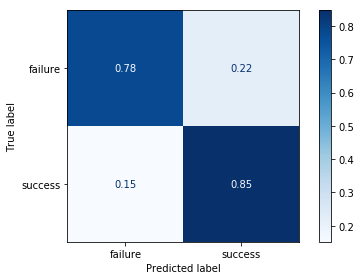


Classification Report
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       265
           1       0.85      0.85      0.85       408

    accuracy                           0.82       673
   macro avg       0.81      0.81      0.81       673
weighted avg       0.82      0.82      0.82       673



In [85]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set
from sklearn.metrics import plot_confusion_matrix
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1.0, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)
print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))

plot_confusion_matrix(gb, X_validation_sub, y_validation_sub,
                      cmap=plt.cm.Blues,
                      display_labels=['failure', 'success'],
                      normalize='true')
plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png')
plt.show()
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))

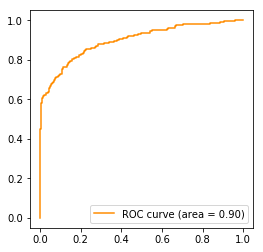

Area under ROC curve = 0.90


In [86]:
# ROC curve and Area-Under-Curve (AUC)
from sklearn.metrics import plot_roc_curve

y_scores_gb = gb.decision_function(X_validation_sub)

fpr_rf, tpr_rf, _ = roc_curve(y_validation_sub, y_scores_gb)
fpr_gb, tpr_gb, _ = roc_curve(y_validation_sub, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(4,4))
plt.plot(fpr_gb, tpr_gb, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.legend()
# plt.savefig('./figures/roc_curve.png')
plt.show()


print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))


country_feature                 0.019560
age_feature                     0.028522
days_since_first_funding        0.119099
category_score                  0.013389
market_score                    0.003769
postA_tweet_num                 0.171970
postA_tweet_freq                0.072347
postA_tweet_avglength           0.026811
postA_tweet_content_richness    0.028863
postA_tweet_interactiveness     0.153442
tweets_pos_topic_score          0.157097
tweets_neg_topic_score          0.115053
tweets_neg_sent_score           0.006199
tweets_neu_sent_score           0.019196
tweets_pos_sent_score           0.041370
tweets_compound_sent_score      0.023312
dtype: float64


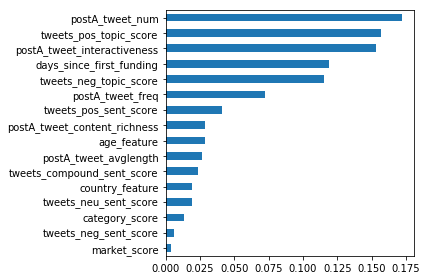

In [87]:
# feature importances.
print(pd.Series(gb.feature_importances_, index=selected_features[:-1]))
pd.Series(gb.feature_importances_, index=selected_features[:-1]).sort_values(ascending=True).plot(kind='barh', )
plt.tight_layout()
# plt.savefig('./figures/feature_importance.png')
plt.show()

In [24]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
# with open(processed_data_dir + '/model_xgb_2.pkl', 'wb') as f:
#     pickle.dump(clf, f)

new_clf = pickle.load(open(processed_data_dir + '/model_xgb_2.pkl', 'rb'))
print(new_clf.predict_proba(X_test))

[[0.68274308 0.31725692]
 [0.67070793 0.32929207]
 [0.45737244 0.54262756]
 ...
 [0.63624737 0.36375263]
 [0.17687136 0.82312864]
 [0.56958127 0.43041873]]


In [23]:
# save data.
X_test.shape

(1155, 16)